In [1]:
import os

import pandas
import numpy
from fbprophet import Prophet
import matplotlib
import matplotlib.pyplot as plt

from h3 import h3

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.style.use('seaborn-pastel')


Importing plotly failed. Interactive plots will not work.


## Table Of Contents

1. [Loading Data](#data)
2. [The HierarchyTree class](#hier)
    1. [Hierarchies and their children](#child)
    2. [Tree Capabilities](#capabilities)
    3. [Visualisations](#viz)
    4. [From Hierachy to Pandas](#pandas)
3. [Modeling with HierarchicalProphet](#hier)
4. [References](#refs)
5. [Modeling with HierarchicalProphet](#refs)
6. [Missing Features](#feat)
7. [Future Work](#todo)


<a id=data ><a/> 
### Loading Data

Data for this tutorial can be downloaded from [here](https://osf.io/v8qax/).
It contains events with some associated varibales happening in germany at specific lat longs.
 



In [4]:
df = pandas.read_csv('../../scikit-hts-extras/power.csv', encoding = "latin", parse_dates=['event_ts'], index_col='event_ts')

In [6]:
df.head()

,peak,lat,lon,power,city,country,energy
event_ts,,,,,,,
2019-08-29 21:01:20.180,8.0,52.508079,13.423046,11.0,berlin,germany,0.15
2019-07-27 08:48:23.448,84.0,50.119352,8.681800,291.0,frankfurt,germany,0.40
2019-09-03 17:34:30.932,523.0,48.133009,11.565324,2218.0,munich,germany,1.80
2019-08-29 16:00:43.357,575.0,50.112304,8.682124,634.0,frankfurt,germany,2.00
2019-08-04 14:47:07.771,704.0,50.108435,8.673832,1274.0,frankfurt,germany,2.40


In [7]:
df.city.value_counts()

berlin       88883
frankfurt    68319
munich       54824
cologne      52521
hamburg      47377
dortmund     38076
Name: city, dtype: int64

<a id=hier ><a/> 
### Building the Hierarchy Tree

`scikit-hts`'s core data structure is the `HierarchyTree`. At its core, it is simply an [n-ary tree](https://en.wikipedia.org/wiki/M-ary_tree), a recursive data structre where each node is specified by:

- A human readable key, such as 'germany', 'total', 'berlin', or '881f15ad61fffff'
- An item, represented by a `pandas.Series`, which contains the actual data about that node



This is the format of this tree                    
                                                        
    Level                             Node Key                          # of nodes
                                                              
      1                                  t                                   1
   
      2                 a                b                   c               3
            
      3           aa   ab             ba   bb             ca   cb            6
             
      4      aaa aab   aba abb   baa bab   bba bbb   caa cab   cba cbb       12
      
      
      
In our use case for germany, the true format is the following: 


    Level                                   Node Key                           # of nodes
                                                              
      1                                     germany                                 1
   
      2                 berlin              hamburg            Munich      ...      5
            
      3          hex1  hex2   ...      hex7  hex8  ...     hex11  hex12 ...   ...  114
             
      4                            .....     hex 7 level    .....                  520
      
      
As you can see the number of nodes increases significantly with each level. However, many of these nodes will have barely any observations, as they simply exist due to the fact at _some point_ in the timespan considered a ride happen to start there. 

In order to make ther problem tractable, and to be able to actually perform predictions/forecasting at the levels desired, the tree building  data structure accepts a `min_count` parameter, which will remove any node having less than the desired number of observations. 

In [9]:
from hts.hierarchy import HierarchyTree

In [10]:
sample = df.head(10000)

In [42]:
ht = HierarchyTree.from_geo_events(df=df, 
                                   lat_col='lat', 
                                   lon_col='lon',
                                   nodes=('city', 'hex_index_6', 'hex_index_7', 'hex_index_8'),
                                   levels=(6, 8),
                                   resample_freq='1H',
                                   min_count=0.5
                                  )

In [43]:
len(ht.traversal_level())

95

In [44]:
ht

- total
   |- berlin
   |  |- 861f1d4d7ffffff
   |  |  |- 871f1d4d6ffffff
   |  |  |- 871f1d4d0ffffff
   |  |  - 871f1d4d2ffffff
   |  |- 861f1d48fffffff
   |  |  |- 871f1d48bffffff
   |  |  |  - 881f1d48b9fffff
   |  |  |- 871f1d489ffffff
   |  |  |  |- 881f1d4891fffff
   |  |  |  |- 881f1d4895fffff
   |  |  |  |- 881f1d4899fffff
   |  |  |  - 881f1d489dfffff
   |  |  |- 871f1d48affffff
   |  |  |- 871f1d488ffffff
   |  |  |  - 881f1d4883fffff
   |  |  |- 871f1d48effffff
   |  |  - 871f1d48dffffff
   |  |- 861f18b27ffffff
   |  |  |- 871f18b24ffffff
   |  |  - 871f18b25ffffff
   |  |- 861f1d49fffffff
   |  |  - 871f1d49dffffff
   |  - 861f1d4f7ffffff
   |     - 871f1d4f2ffffff
   |- frankfurt
   |  |- 861faeaafffffff
   |  |  |- 871faeaa9ffffff
   |  |  |  |- 881faeaa9bfffff
   |  |  |  |- 881faeaa9dfffff
   |  |  |  |- 881faeaa91fffff
   |  |  |  |- 881faeaa95fffff
   |  |  |  - 881faeaa99fffff
   |  |  |- 871faeaadffffff
   |  |  |  |- 881faeaad3fffff
   |  |  |  - 881faeaad7fffff
 

In [45]:
ht.children[2].children[0].key

'861f8d7a7ffffff'

What we are building here is a tree as the one depicted above. One that has as the root level the Germany-wide time-series data, and as children the city-level time series, which in turn have as children the h3 encoded geographical locations (beginning at the 6 level of granulairty), which in turn have as children the 7th and finally 8th level of granularity time-series. 

Since we have _events_ data, and what we really need is a time-series in order to do modeling, we also specify the resampling frequency. We also specifiy the columns where the latitude and longitude values are located in the events data frame.

In [46]:
print(f' ht is of type: {type(ht)}\n has as key: {ht.key}')

 ht is of type: <class 'hts.hierarchy.HierarchyTree'>
 has as key: total


The item inside the `ht` is in fact the total of the children's node -- basically the aggregated values for each hierarchy level

<a id=child ><a/> 
### Hierarchy Children

Being hierarchial in nature, it means that our HierarchyTree will also have `children`

In [31]:
print(', '.join([h.key for h in ht.children]))

dortmund, cologne, hamburg, munich, berlin, frankfurt


<a id=capabilities ><a/> 
### Tree Capabilities

Having the tree built, we can perform a series of opearation on it. Most importantly, we can visualize it (in case we are dealing with geographical data). `scikit-hts` was built with this use-case in mind, but nothing prevents us from using it with different type of hierarchical data. It just fits well our use-case. 

<a id=viz ><a/> 
#### Germany Level Visualization

In [48]:
ht.visualizer.create_map()

#### Berlin Level Visualization
We can also access a node by querying it by its key. Recall that each node gets a unique key based on its name. In the case we pick a city, all of its children will be the hex ids of their geographical location. 

In [49]:
berlin = ht.get_node('berlin')
berlin.visualizer.create_map()

<a id=pandas ><a/> 
#### Hierarchy As Pandas

We can also very easily transform our hierarchy tree into a pandas DataFrame quite easily.

In [50]:
berlin_df = berlin.to_pandas()
berlin_df.head(3)

,berlin,861f1d4d7ffffff,861f1d48fffffff,861f18b27ffffff,861f1d49fffffff,861f1d4f7ffffff,871f1d4d6ffffff,871f1d4d0ffffff,871f1d4d2ffffff,871f1d48bffffff,...,871f18b24ffffff,871f18b25ffffff,871f1d49dffffff,871f1d4f2ffffff,881f1d48b9fffff,881f1d4891fffff,881f1d4895fffff,881f1d4899fffff,881f1d489dfffff,881f1d4883fffff
ds,,,,,,,,,,,,,,,,,,,,,
2019-07-10 00:00:00,3,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-10 01:00:00,8,3.0,3.0,1.0,0.0,1.0,0.0,3.0,NaN,1.0,...,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2019-07-10 02:00:00,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN


<a id=model ><a/> 
## Modeling

Now that we have a grasp of how the internals work, we can proceed on to the modeling. The modeling works in the following fashion:

1. Generate a time-series model for each node in the Hierarchy Tree
2. Produce predictions for each of the models
3. Correct the predictions based on a pre-specified strategy

Multiple strategies are implemented. For a holistic treatment, refer to the literature in Handyman ([Handyman, 2015](#ref-1))

In particular, the following strategies apply:

- `OLS` - optimal combination using ordinary least squares (Default), 
- `WLSS` - optimal combination using structurally weighted least squares, 
- `WLSV` - optimal combination using variance weighted least squares, 
- `FP` - forcasted proportions (top-down)
- `PHA` - proportions of historical averages (top-down)
- `AHP` - average historical proportions (top-down)
- `BU` - bottom-up (simple addition)





In [51]:
from hts import HTSRegressor

In [38]:
hp = HTSRegressor(transform=None, freq='3H')
hp.fit(nodes=ht)

/Users/carlomazzafero/projects/scikit-hts/hts/transforms.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col], self.lam = self.func(X[col])


TypeError: __init__() got an unexpected keyword argument 'capacity'

Now that the heavy lifting is done, all the models, predictions, and parameters are stored in a easily accessible format: 

In [71]:
preds = hp.predict_future() 

In [77]:
# Let's get the step-ahed prediction for berlin
preds['berlin'].tail(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1197,2019-12-06 15:00:00,63.145463,138.18384,644.536609,63.145463,63.145463,316.994447,316.994447,316.994447,274.6572,274.6572,274.6572,42.337248,42.337248,42.337248,0.0,0.0,0.0,383.348201


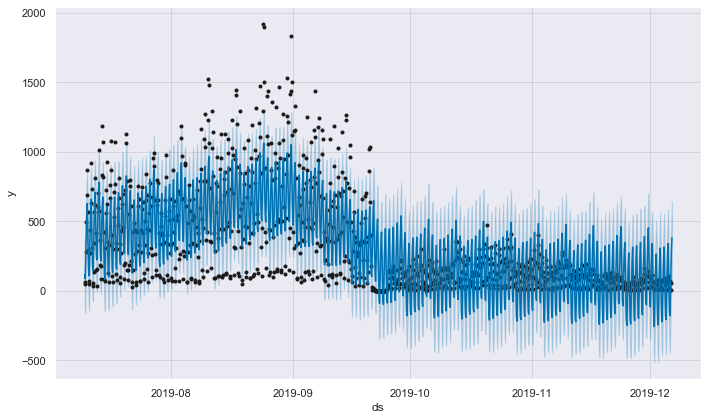

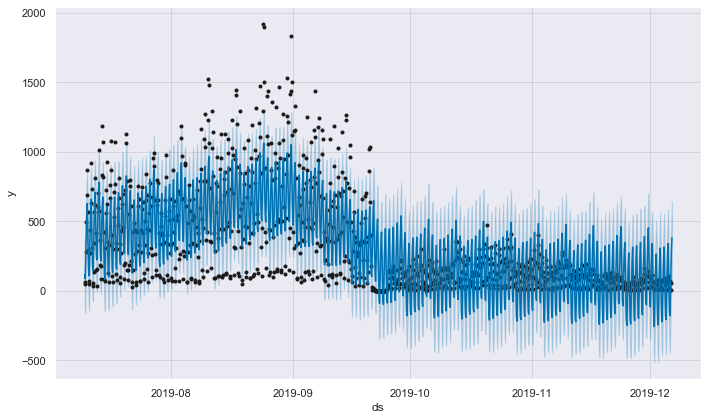

In [80]:
pandas.plotting.register_matplotlib_converters()  # required for plotting time series

hp.model.models['berlin'].plot(preds['berlin'])

In [27]:
preds['total'].set_index('ds').yhat.plot()

NameError: name 'preds' is not defined

In [28]:
import pandas
import numpy
from datetime import datetime
from hts import HierarchyTree
from hts.utils import load_sample_hierarchical_mv_data, load_hierarchical_sine_data

In [40]:
mobility = load_sample_hierarchical_mv_data()

In [6]:
hier = {
    'total': ['CH', 'SLU', 'BT', 'OTHER'], 
    'CH': ['CH-07', 'CH-02', 'CH-08', 'CH-05', 'CH-01'],
    'SLU': ['SLU-15', 'SLU-01', 'SLU-19', 'SLU-07', 'SLU-02'], 
    'BT': ['BT-01', 'BT-03'],
    'OTHER': ['WF-01', 'CBD-13']
}
exogenous = {k: ['precipitation', 'temp'] for k in mobility.columns if k not in ['precipitation', 'temp']}

ht = HierarchyTree.from_nodes(hier, mobility, exogenous=exogenous)
ht.item

,total,precipitation,temp
starttime,,,
2014-10-13,240,0.00,62.0
2014-10-14,394,0.11,59.0
2014-10-15,230,0.45,58.0
2014-10-16,338,0.00,61.0
2014-10-17,234,0.14,60.0
...,...,...,...
2016-08-27,125,0.00,66.0
2016-08-28,170,0.00,68.0
2016-08-29,149,0.00,68.0


In [24]:
dta.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
2008-07-01,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008-10-01,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009-01-01,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009-04-01,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
2009-07-01,2009.0,3.0,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


                           Statespace Model Results                           
Dep. Variable:                   infl   No. Observations:                  203
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -453.500
Date:                Wed, 12 Feb 2020   AIC                            918.999
Time:                        13:17:06   BIC                            938.878
Sample:                    01-01-1959   HQIC                           927.041
                         - 07-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6942      0.326      2.128      0.033       0.055       1.334
ar.L1          0.3597      0.047      7.629      0.000       0.267       0.452
ar.L2          0.1869      0.048      3.928      0.0

2009-10-01    3.106093
2010-01-01    3.455031
2010-04-01    3.490788
2010-07-01    3.429073
Freq: QS-JAN, dtype: float64

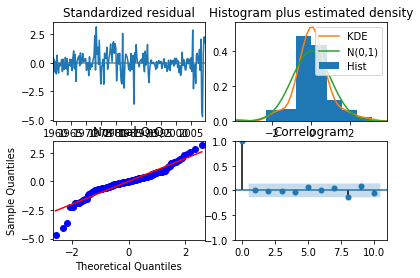

In [26]:
dta = sm.datasets.macrodata.load_pandas().data
# Make sure we have an index with an associated frequency, so that
# we can refer to time periods with date strings or timestamps
dta.index = pandas.date_range('1959Q1', '2009Q3', freq='QS')

# Step 1: construct an SARIMAX model for US inflation data
model = sm.tsa.SARIMAX(dta.infl, order=(4, 0, 0), trend='c')

# Step 2: fit the model's parameters by maximum likelihood
results = model.fit()

# Step 3: explore / use results

# - Print a table summarizing estimation results
print(results.summary())

# - Print only the estimated parameters
print(results.params)

# - Create diagnostic figures based on standardized residuals:
#   (1) time series graph
#   (2) histogram
#   (3) Q-Q plot
#   (4) correlogram
results.plot_diagnostics()


# - Forecast the next 4 values
results.forecast(4)



In [9]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
mdata = sm.datasets.macrodata.load_pandas().data


dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

data 

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
...,...,...,...
2008-09-30,-0.006781,-0.008948,-0.017836
2008-12-31,-0.013805,-0.007843,-0.069165
2009-03-31,-0.016612,0.001511,-0.175598
2009-06-30,-0.001851,-0.002196,-0.067561


In [8]:
model = VAR(data)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [20]:
numpy.random.seed(12)

In [8]:
from importlib import reload
import hts
from hts.utils import load_hierarchical_sine_data
reload(hts)
from hts import HierarchyTree

s, e = datetime(2019, 1, 15), datetime(2019, 10, 15)
dti = load_hierarchical_sine_data(s, e)
hier = {'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}

In [9]:
dti.head()

,total,a,b,c,d,aa,ab,aaa,aab,ba,bb,bc,ca,cb,cc,cd
2019-01-15 00:02:14.597958,10.210609,1.599214,1.573817,0.156622,6.880957,1.572355,0.026860,1.521458,0.050897,0.198489,0.998138,0.377189,0.016552,0.040402,0.091455,0.008212
2019-01-15 00:04:28.663093,5.789237,1.924542,0.479917,3.381084,0.003693,0.371092,1.553450,0.340401,0.030691,0.282280,0.105798,0.091839,0.022216,0.672258,1.436706,1.249903
2019-01-15 00:19:59.810849,3.858035,0.335411,0.596102,2.699070,0.227451,0.016977,0.318434,0.016773,0.000204,0.159239,0.334741,0.102123,0.471253,1.268519,0.128189,0.831109
2019-01-15 00:36:41.332576,8.494638,0.250057,4.156472,3.928292,0.159818,0.239017,0.011040,0.196497,0.042520,2.025372,0.578805,1.552295,0.002799,0.286395,1.914109,1.724989
2019-01-15 00:42:41.647707,-1.443746,-0.179026,-0.049688,-0.081129,-1.133903,-0.085624,-0.093402,-0.082389,-0.003234,-0.015955,-0.030897,-0.002836,-0.017652,-0.009615,-0.039085,-0.014777


In [6]:
ht = HierarchyTree.create_node(hier, dti)

In [8]:
pprint_tree(ht)

- total
   |- a
   |  |- aa
   |  |  |- aaa
   |  |  - aab
   |  - ab
   |- b
   |  |- ba
   |  - bb
   - c
      |- ca
      |- cb
      |- cc
      - cd


In [58]:
ht = HierarchyTree()

array([  3.57035744, 262.68971009, 274.022406  , ..., 127.18550083,
       271.24661618, 204.9178955 ])

In [12]:
ht = HierarchyTree.from_df(hier, dti)

here
total
{'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}
a
{'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}
b
{'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}
c
{'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}
aa
{'total': ['a', 'b', 'c'], 'a': ['aa', 'ab'], 'aa': ['aaa', 'aab'], 'b': ['ba', 'bb'], 'c': ['ca', 'cb', 'cc', 'cd']}


In [17]:
pprint_tree(ht)

- total
   |- a
   |  |- aa
   |  |  |- aaa
   |  |  - aab
   |  - ab
   |- b
   |  |- ba
   |  - bb
   - c
      |- ca
      |- cb
      |- cc
      - cd


<a id=refs ><a/> 
## References

[Forecasting: Principles and Practice. Rob J Hyndman and George Athanasopoulos. Monash University, Australia <a name="ref-1"/>](https://otexts.com/fpp2/hierarchical.html)


<a id=feat ><a/> 
### Missing Features 


__short term__
- Allow for multivariate input                                                 

__long term__
- Expand beyond prophet by letting the user choose between a set of forcasting methodologies

    
<a id=todo ><a>
### Future Work - To Do's


- Use interpolation to fill any gaps on training data
- Predict ride starts based on app openings
- Discrepancy between app openings and ride starts -- predict both
- Model something differernt than ride starts